In [1]:
import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import torch.nn as nn
import torch.optim as optim
from focal_loss.focal_loss import FocalLoss
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler, RandomSampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from autoencoder_utils import *

In [2]:
# Filepath to embeddings
fname = '/mnt/mimic/data/HAIM/mimic_extras/embeddings.csv'

quantization_config = BitsAndBytesConfig(load_in_4bit=True, 
                                         bnb_4bit_use_double_quant=True,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_compute_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2b", device_map="auto", quantization_config=quantization_config)

# Read data & extract labels and features
df = pd.read_csv(fname)


# Load train/val sets and create data loaders
batch_size = 32

Data = DataSplit(df)
Data.split_data('all')
X, V = Data.get_data()

torch.manual_seed(42)


Data.y_train = Data.y_train.apply(lambda lst: [2 if x == -1 else x for x in lst])
Data.y_val = Data.y_val.apply(lambda lst: [2 if x == -1 else x for x in lst])

train_set = CustomDataset(X.values.tolist(), Data.y_train.tolist())
val_set = CustomDataset(V.values.tolist(), Data.y_val.tolist())

transposed_Y = list(map(list, zip(*Data.y_train.tolist())))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=5)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=5)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/liv/multimodal_healthcare/autoencoder_utils.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_death_small48['y'] = 1
/home/liv/multimodal_healthcare/autoencoder_utils.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alive_big48['y'] = 0
/home/liv/multimodal_healthcare/autoencoder_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [3]:
# Setting model and hyperparameters
vd_model = torch.load('multiresults/vd.pth').to('cuda')
vmd_model = torch.load('multiresults/vmd.pth').to('cuda')

ts_pe_model = torch.load('multiresults/ts_pe.pth').to('cuda')
ts_ce_model = torch.load('multiresults/ts_ce.pth').to('cuda')
ts_le_model = torch.load('multiresults/ts_le.pth').to('cuda')

n_rad_model = torch.load('multiresults/n_rad.pth').to('cuda')
models = [vd_model, vmd_model, ts_pe_model, ts_ce_model, ts_le_model, n_rad_model]

In [4]:
def per_task_accuracy_scores(probabilities, hard_preds, labels):
    batch_per_class_probs = [[] for _ in range(12)]
    batch_per_class_preds = [[] for _ in range(12)]
    batch_per_class_labels = [[] for _ in range(12)]

    for i, class_tensor in enumerate(hard_preds):
            batch_per_class_preds[i].append(class_tensor)
            batch_per_class_labels[i].append(labels[i])
            batch_per_class_probs[i].append(probabilities[i])
        
    per_class_acc_batch_avg = []
    for i,hard_preds in enumerate(batch_per_class_preds):
        mask = torch.isnan(batch_per_class_labels[i][0])
        masked_labels = batch_per_class_labels[i][0][~mask]
        masked_preds = hard_preds[0][~mask]
        if len(masked_labels) == 0:
            continue
        else:
            per_class_acc_batch_avg.append((masked_preds == masked_labels).float().mean().item())
    
    acc_batch_avg = sum(per_class_acc_batch_avg) / len(per_class_acc_batch_avg)

    return acc_batch_avg

In [5]:
def predict(models, val_loader, gemma):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    per_class_probs = [[] for _ in range(12)]
    per_class_preds = [[] for _ in range(12)]
    per_class_labels = [[] for _ in range(12)]

    for model in models:
        model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x, y.to(device)

            vd_inputs = x['vd'].to(device)
            vmd_inputs = x['vmd'].to(device)
            ts_pe_inputs = x['ts_pe'].to(device)
            ts_ce_inputs = x['ts_ce'].to(device)
            ts_le_inputs = x['ts_le'].to(device)
            n_rad_inputs = x['n_rad'].to(device)

            encoded_vd = models[0].encoder(vd_inputs)
            encoded_vmd = models[1].encoder(vmd_inputs)
            encoded_ts_pe = models[2].encoder(ts_pe_inputs)
            encoded_ts_ce = models[3].encoder(ts_ce_inputs)
            encoded_ts_le = models[4].encoder(ts_le_inputs)
            encoded_n_rad = models[5].encoder(n_rad_inputs)

            decoded_vd = models[0].decoder(encoded_vd)
            decoded_vmd = models[1].decoder(encoded_vmd)
            decoded_ts_pe = models[2].decoder(encoded_ts_pe)
            decoded_ts_ce = models[3].decoder(encoded_ts_ce)
            decoded_ts_le = models[4].decoder(encoded_ts_le)
            decoded_n_rad = models[5].decoder(encoded_n_rad)

            inputs = [vd_inputs, vmd_inputs, ts_pe_inputs, ts_ce_inputs, ts_le_inputs, n_rad_inputs]
            decoded = [decoded_vd, decoded_vmd, decoded_ts_pe, decoded_ts_ce, decoded_ts_le, decoded_n_rad]

            concat_emb = torch.cat((encoded_vd.view(-1,1,2048).to(torch.float16), encoded_vmd.view(-1,1,2048).to(torch.float16), 
                                encoded_ts_pe.view(-1,1,2048).to(torch.float16), encoded_ts_ce.view(-1,1,2048).to(torch.float16), 
                                encoded_ts_le.view(-1,1,2048).to(torch.float16), encoded_n_rad.view(-1,1,2048).to(torch.float16)),
                                  dim=1).to(device)

            binary_logits, ternary_logits = custom_output(concat_emb, gemma)
            probabilities, hard_preds, labels = output_to_label(binary_logits, ternary_logits, labels)

            for i, class_tensor in enumerate(hard_preds):
                per_class_preds[i].append(class_tensor)
                per_class_labels[i].append(labels[i])
                per_class_probs[i].extend(probabilities[i])

            acc_batch_avg = per_task_accuracy_scores(probabilities, hard_preds, labels)
            print(acc_batch_avg)

    return per_class_preds, per_class_labels, per_class_probs

In [6]:
per_class_preds, per_class_labels, per_class_probs = predict(models, val_loader, gemma)

0.7359068718823519
0.6693182021379471
0.5512126132845878
0.7374488443136216
0.6622362345457077
0.6296153903007508
0.7505565315485001
0.5993075235323473
0.5753856910900637
0.7046536938710646
0.5894164939721426
0.47446316555142404
0.6773658476092599
0.5989638343453407
0.7486626282334328
0.5802291076291691
0.7050534963607789
0.5983055084943771
0.5736286782405593
0.7437927289442583
0.6890782849355177
0.6491071494917074
0.6914411349730059
0.8454996564171531
0.7515837192535401
0.6418545733798634
0.5053661682388999
0.5539073662625419
0.6205898374319077
0.7298942223191262
0.5869633913040161
0.6523501466621052
0.7875360876321793
0.5819651037454605
0.8419491499662399
0.7762770712375641
0.5390426055951552
0.5999610990285873
0.534583343565464
0.7055685430765152
0.5879402898929336
0.6332638904452323
0.5738095417618752
0.5829545468091964
0.5677726519378749
0.5742131248116493
0.5514078763398257
0.6737855090336367
0.6299823224544525
0.6266613379120827
0.5865972310304641
0.6244411289691925
0.7721421062

In [7]:
print(len(per_class_labels))
for i,class_preds in enumerate(per_class_preds):
    print(len(class_preds[0]))
    print(len(per_class_labels[i][0]))
    print(len(per_class_probs[i][0]))

12
32
32
3
32
32
3
32
32
3
32
32
3
32
32
3
32
32
3
32
32
3
32
32
3
32
32
3
32
32
3
32
32
2
32
32
2


In [31]:

from sklearn.preprocessing import label_binarize

f1_scores = []
auc_scores = []
precisions = []
recalls = []
accuracies = []
matrices = []
fpr_tpr = []
roc_aucs = []
for i,class_preds in enumerate(per_class_preds[:10]):
    preds_arrays = [t.cpu().numpy() for t in class_preds]
    preds = np.concatenate(preds_arrays)

    labels_arrays = [t.cpu().numpy() for t in per_class_labels[i]]
    labels = np.concatenate(labels_arrays)
    probs_arrays = [t.cpu().numpy() for t in per_class_probs[i]]
    probs = np.stack(probs_arrays)

    mask = np.isnan(labels)
    masked_labels = labels[~mask]
    masked_preds = preds[~mask]
    masked_probs = probs[~mask,:]
    f1_scores.append(metrics.f1_score(masked_labels, masked_preds, average='micro'))
    auc_scores.append(metrics.roc_auc_score(masked_labels, masked_probs, average='weighted', multi_class='ovr'))
    precisions.append(metrics.precision_score(masked_labels, masked_preds, average='weighted'))
    recalls.append(metrics.recall_score(masked_labels, masked_preds, average='weighted'))
    accuracies.append(metrics.accuracy_score(masked_labels, masked_preds))
    matrices.append(metrics.confusion_matrix(masked_labels, masked_preds))

    #binary_labels = label_binarize(masked_labels, classes=np.unique(masked_labels))
    #fpr, tpr, thresholds = metrics.roc_curve(binary_labels[:, i], masked_probs[:, i])
    #fpr_tpr.append((fpr,tpr))
    #roc_aucs.append(metrics.auc(fpr, tpr))
for i,class_preds in enumerate(per_class_preds[10:], start=10):
    preds_arrays = [t.cpu().numpy() for t in class_preds]
    preds = np.concatenate(preds_arrays)

    labels_arrays = [t.cpu().numpy() for t in per_class_labels[i]]
    labels = np.concatenate(labels_arrays)

    probs_arrays = [t.cpu().numpy() for t in per_class_probs[i]]
    probs = np.stack(probs_arrays)

    mask = np.isnan(labels)
    masked_labels = labels[~mask]
    masked_preds = preds[~mask]
    masked_probs = probs[~mask,:]
    positive_probs = masked_probs[:, 1]
    f1_scores.append(metrics.f1_score(masked_labels, masked_preds, average='micro'))
    auc_scores.append(metrics.roc_auc_score(masked_labels, positive_probs))
    precisions.append(metrics.precision_score(masked_labels, masked_preds))
    recalls.append(metrics.recall_score(masked_labels, masked_preds))
    accuracies.append(metrics.accuracy_score(masked_labels, masked_preds))
    matrices.append(metrics.confusion_matrix(masked_labels, masked_preds))
    fpr, tpr, thresholds = metrics.roc_curve(masked_labels, positive_probs)
    fpr_tpr.append((fpr,tpr))
    roc_aucs.append(metrics.auc(fpr, tpr))

Class: Fracture
F1 score: 0.776566757493188
AUC score: 0.5795241080264311
Precision: 0.7819454838244182
Recall: 0.776566757493188
Accuracy: 0.776566757493188



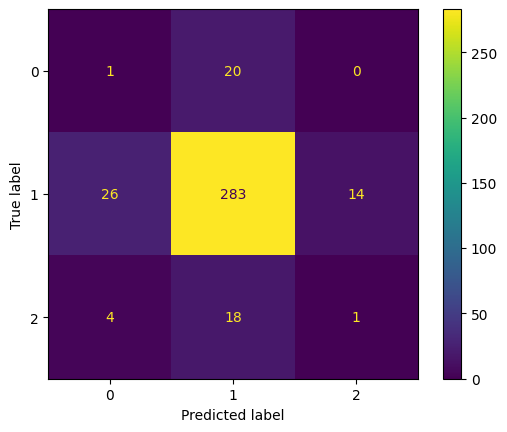

In [32]:
print('Class: Fracture')

print(f'F1 score: {f1_scores[0]}\n'
        f'AUC score: {auc_scores[0]}\n'
        f'Precision: {precisions[0]}\n'
        f'Recall: {recalls[0]}\n'
        f'Accuracy: {accuracies[0]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[0])
matrix.plot()

# fpr, tpr = fpr_tpr[0]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[0])
# roc_curve.plot()

Class: Lung Lesion
F1 score: 0.7884187082405345
AUC score: 0.6721065546861532
Precision: 0.7553632362963569
Recall: 0.7884187082405345
Accuracy: 0.7884187082405345



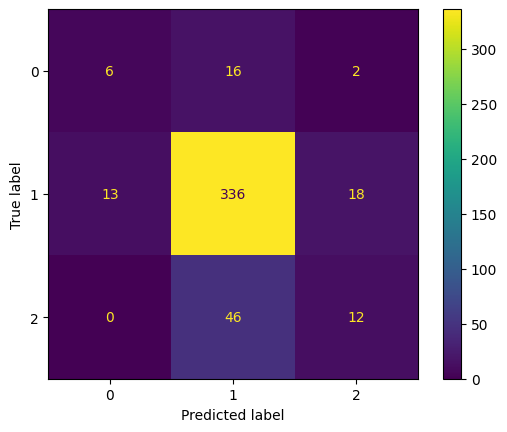

In [33]:
print('Class: Lung Lesion')
print(f'F1 score: {f1_scores[1]}\n'
        f'AUC score: {auc_scores[1]}\n'
        f'Precision: {precisions[1]}\n'
        f'Recall: {recalls[1]}\n'
        f'Accuracy: {accuracies[1]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[1])
matrix.plot()

# fpr, tpr = fpr_tpr[1]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[1])
# roc_curve.plot()

Class: Enlarged Cardiomediastinum
F1 score: 0.3385991058122206
AUC score: 0.5443805931361642
Precision: 0.43892098541439867
Recall: 0.3385991058122206
Accuracy: 0.3385991058122206



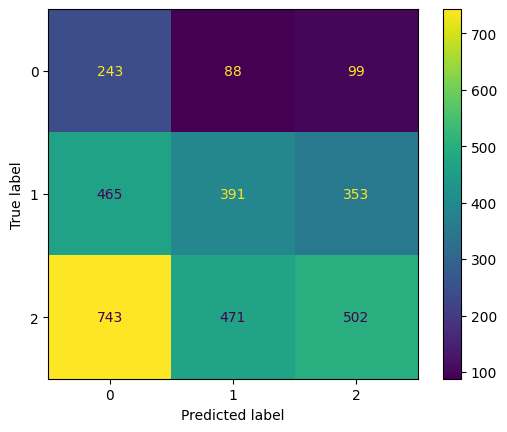

In [34]:
print('Class: Enlarged Cardiomediastinum')
print(f'F1 score: {f1_scores[2]}\n'
        f'AUC score: {auc_scores[2]}\n'
        f'Precision: {precisions[2]}\n'
        f'Recall: {recalls[2]}\n'
        f'Accuracy: {accuracies[2]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[2])
matrix.plot()

# fpr, tpr = fpr_tpr[2]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[2])
# roc_curve.plot()

Class: Consolidation
F1 score: 0.6441971383147854
AUC score: 0.7528140865811748
Precision: 0.6741014926287329
Recall: 0.6441971383147854
Accuracy: 0.6441971383147854



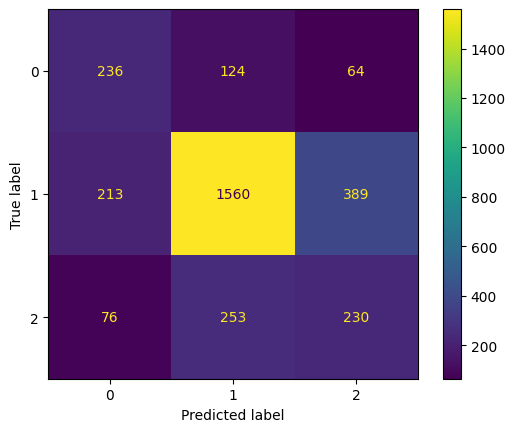

In [35]:
print('Class: Consolidation')
print(f'F1 score: {f1_scores[3]}\n'
        f'AUC score: {auc_scores[3]}\n'
        f'Precision: {precisions[3]}\n'
        f'Recall: {recalls[3]}\n'
        f'Accuracy: {accuracies[3]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[3])
matrix.plot()

# fpr, tpr = fpr_tpr[3]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[3])
# roc_curve.plot()

Class: Pneumonia
F1 score: 0.5609582963620231
AUC score: 0.739513169855921
Precision: 0.5622288358568097
Recall: 0.5609582963620231
Accuracy: 0.5609582963620231



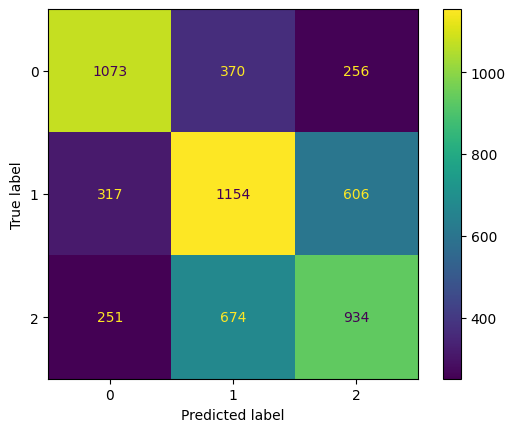

In [36]:
print('Class: Pneumonia')
print(f'F1 score: {f1_scores[4]}\n'
        f'AUC score: {auc_scores[4]}\n'
        f'Precision: {precisions[4]}\n'
        f'Recall: {recalls[4]}\n'
        f'Accuracy: {accuracies[4]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[4])
matrix.plot()

# fpr, tpr = fpr_tpr[4]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[4])
# roc_curve.plot()

Class: Atelectasis
F1 score: 0.6370020723002533
AUC score: 0.684820427705428
Precision: 0.8041172051044986
Recall: 0.6370020723002533
Accuracy: 0.6370020723002533



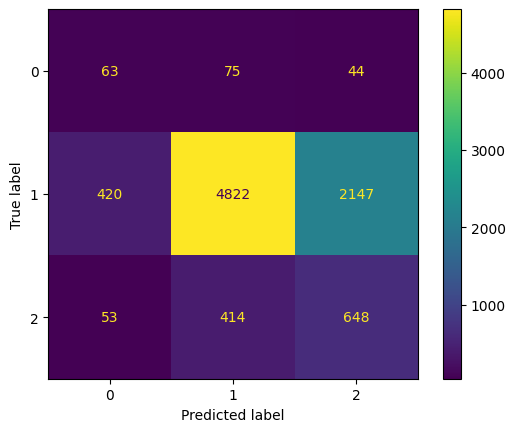

In [37]:
print('Class: Atelectasis')
print(f'F1 score: {f1_scores[5]}\n'
        f'AUC score: {auc_scores[5]}\n'
        f'Precision: {precisions[5]}\n'
        f'Recall: {recalls[5]}\n'
        f'Accuracy: {accuracies[5]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[5])
matrix.plot()

# fpr, tpr = fpr_tpr[5]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[5])
# roc_curve.plot()

Class: Lung Opacity
F1 score: 0.6921842202741079
AUC score: 0.7264321410415884
Precision: 0.8733139179031433
Recall: 0.6921842202741079
Accuracy: 0.6921842202741079



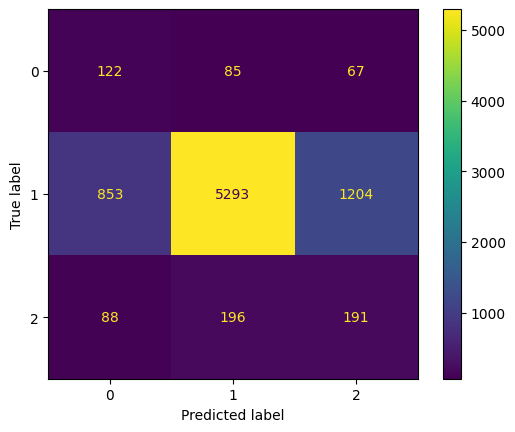

In [38]:
print('Class: Lung Opacity')
print(f'F1 score: {f1_scores[6]}\n'
        f'AUC score: {auc_scores[6]}\n'
        f'Precision: {precisions[6]}\n'
        f'Recall: {recalls[6]}\n'
        f'Accuracy: {accuracies[6]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[6])
matrix.plot()

# fpr, tpr = fpr_tpr[6]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[6])
# roc_curve.plot()

Class: Pneumothorax
F1 score: 0.7133133364097831
AUC score: 0.7662793417906432
Precision: 0.7915218818103196
Recall: 0.7133133364097831
Accuracy: 0.7133133364097831



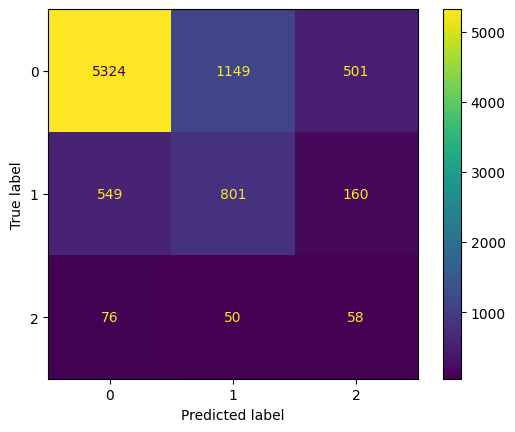

In [39]:
print('Class: Pneumothorax')
print(f'F1 score: {f1_scores[7]}\n'
        f'AUC score: {auc_scores[7]}\n'
        f'Precision: {precisions[7]}\n'
        f'Recall: {recalls[7]}\n'
        f'Accuracy: {accuracies[7]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[7])
matrix.plot()

# fpr, tpr = fpr_tpr[7]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[7])
# roc_curve.plot()

Class: Edema
F1 score: 0.5324675324675324
AUC score: 0.7395905778845505
Precision: 0.6098414342592234
Recall: 0.5324675324675324
Accuracy: 0.5324675324675324



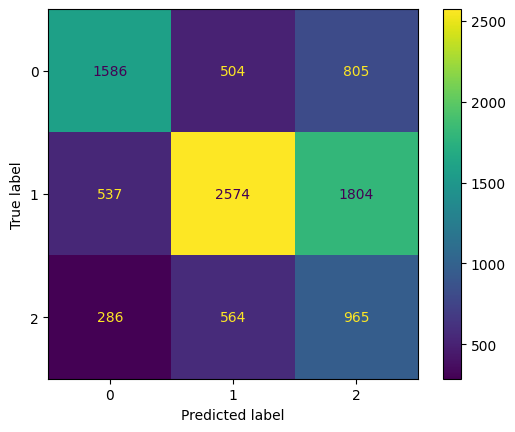

In [40]:
print('Class: Edema')
print(f'F1 score: {f1_scores[8]}\n'
        f'AUC score: {auc_scores[8]}\n'
        f'Precision: {precisions[8]}\n'
        f'Recall: {recalls[8]}\n'
        f'Accuracy: {accuracies[8]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[8])
matrix.plot()

# fpr, tpr = fpr_tpr[8]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[8])
# roc_curve.plot()

Class: Cardiomegaly
F1 score: 0.634824414715719
AUC score: 0.773217981224398
Precision: 0.7314077681167589
Recall: 0.634824414715719
Accuracy: 0.634824414715719



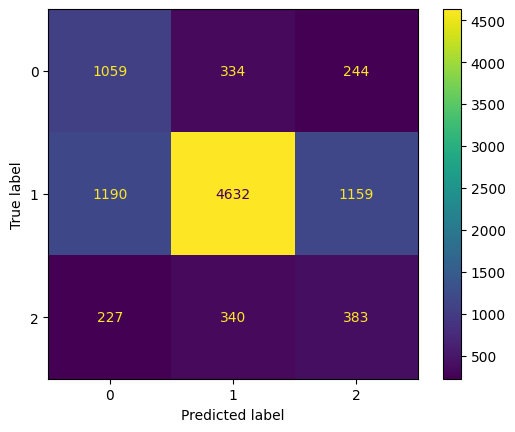

In [41]:
print('Class: Cardiomegaly')
print(f'F1 score: {f1_scores[9]}\n'
        f'AUC score: {auc_scores[9]}\n'
        f'Precision: {precisions[9]}\n'
        f'Recall: {recalls[9]}\n'
        f'Accuracy: {accuracies[9]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[9])
matrix.plot()

# fpr, tpr = fpr_tpr[9]
# roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[9])
# roc_curve.plot()

Class: Length-of-Stay
F1 score: 0.7550234207415839
AUC score: 0.7804666821676999
Precision: 0.21436697545912564
Recall: 0.6338298894762133
Accuracy: 0.7550234207415839



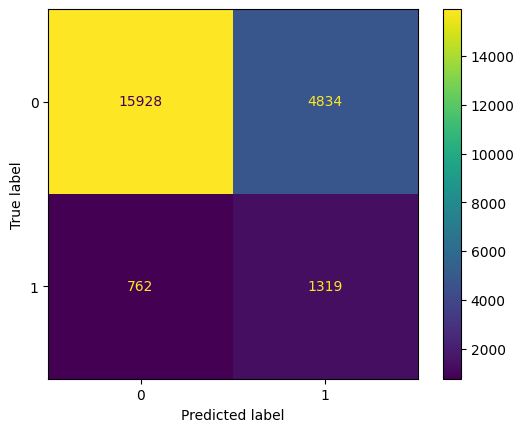

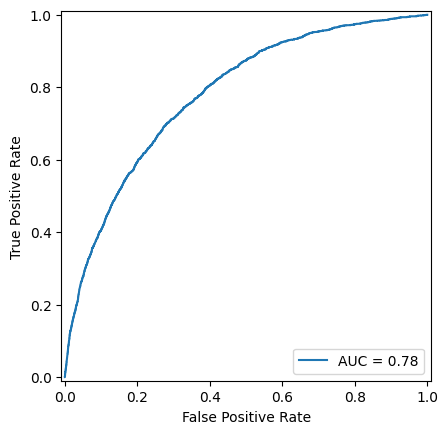

In [45]:
print('Class: Length-of-Stay')
print(f'F1 score: {f1_scores[10]}\n'
        f'AUC score: {auc_scores[10]}\n'
        f'Precision: {precisions[10]}\n'
        f'Recall: {recalls[10]}\n'
        f'Accuracy: {accuracies[10]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[10])
matrix.plot()

fpr, tpr = fpr_tpr[0]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[0])
roc_curve.plot()

Class: 48-hour Mortality
F1 score: 0.8907761677537976
AUC score: 0.8457775768897153
Precision: 0.1033672670321065
Recall: 0.5628997867803838
Accuracy: 0.8907761677537976



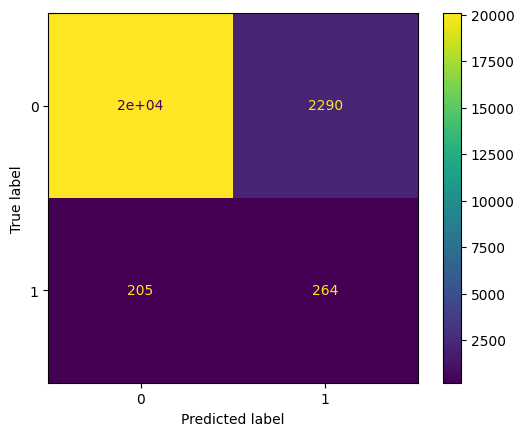

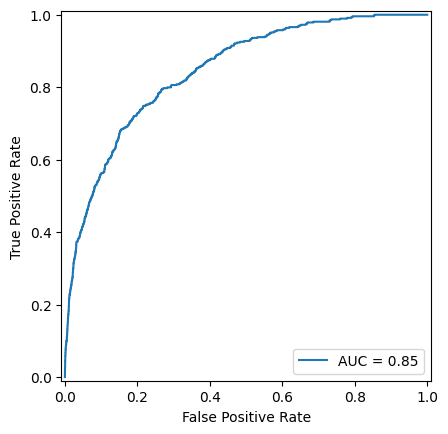

In [46]:
print('Class: 48-hour Mortality')
print(f'F1 score: {f1_scores[11]}\n'
        f'AUC score: {auc_scores[11]}\n'
        f'Precision: {precisions[11]}\n'
        f'Recall: {recalls[11]}\n'
        f'Accuracy: {accuracies[11]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[11])
matrix.plot()

fpr, tpr = fpr_tpr[1]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[1])
roc_curve.plot()